## Gibbs Sampling Algorithm ##

### Set up

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

import os
import os.path as osp
from datetime import datetime

# ROOT = osp.join('/content', 'drive', 'My Drive', 'CS5340', 'project')
ROOT = '.'

In [2]:
num_features = 13
N = 10000
feature_index_map = {'age': 0, 'gender': 1, 'chronical': 2, 'fever_risk': 3, 'cough_risk': 4, 'shortness_risk': 5, 'sputum_risk': 6, 'diarrhea_risk': 7, 'myalgia_risk': 8, \
                     'fatigue_risk': 9, 'heart_risk': 10, 'chest_risk': 11, 'headache_risk': 12}

### Initialize dictionary for ground truth model

In [3]:
age = [0.03518, 0.02412, 0.12161, 0.17789, 0.13266, 0.18392, 0.14271, 0.11055, 0.07136] # 0, 1,  ...., 8
gender = [0.58193, 0.41807] # Male: 0  Female: 1
prior_dict = {"age":age, "gender": gender} 

chronical_age_gender = {  # [false, true]
    "0_0": [0.928571429, 0.071428571],
    "0_1": [0.923076923, 0.076923077],
    "1_0": [0.928571429, 0.071428571],
    "1_1": [0.928571429, 0.071428571],
    "2_0": [0.980392157, 0.019607843],
    "2_1": [0.945945946, 0.054054054],
    "3_0": [0.95, 0.05],
    "3_1": [0.972972973, 0.027027027],
    "4_0": [0.903846154, 0.096153846],
    "4_1": [0.894736842, 0.105263158],
    "5_0": [0.742424242, 0.257575758],
    "5_1": [0.884615385, 0.115384615],
    "6_0": [0.578947368, 0.421052632],
    "6_1": [0.696969697, 0.303030303],
    "7_0": [0.442307692, 0.557692308],
    "7_1": [0.714285714, 0.285714286],
    "8_0": [0.515151515, 0.484848485],
    "8_1": [0.647058824, 0.352941176],
    }

risk_age_gender_chronical = {  # [low, high]
    "0_0_1": [0.5, 0.5], 
    "0_0_0": [0.928571429, 0.071428571], 
    "0_1_1": [0.5, 0.5], 
    "0_1_0": [0.923076923, 0.076923077], 
    "1_0_1": [0.5, 0.5], 
    "1_0_0": [0.928571429, 0.071428571], 
    "1_1_1": [0.5, 0.5], 
    "1_1_0": [0.9, 0.1], 
    "2_0_1": [0.5, 0.5], 
    "2_0_0": [0.980392157, 0.019607843], 
    "2_1_1": [0.666666667, 0.333333333], 
    "2_1_0": [0.972222222, 0.027777778], 
    "3_0_1": [0.6, 0.4], 
    "3_0_0": [0.922077922, 0.077922078], 
    "3_1_1": [0.5, 0.5], 
    "3_1_0": [0.972972973, 0.027027027], 
    "4_0_1": [0.166666667, 0.833333333], 
    "4_0_0": [0.875, 0.125], 
    "4_1_1": [0.4, 0.6], 
    "4_1_0": [0.971428571, 0.028571429], 
    "5_0_1": [0.277777778, 0.722222222], 
    "5_0_0": [0.76, 0.24], 
    "5_1_1": [0.333333333, 0.666666667], 
    "5_1_0": [0.972222222, 0.027777778], 
    "6_0_1": [0.16, 0.84], 
    "6_0_0": [0.647058824, 0.352941176], 
    "6_1_1": [0.181818182, 0.818181818], 
    "6_1_0": [0.75, 0.25], 
    "7_0_1": [0.233333333, 0.766666667], 
    "7_0_0": [0.416666667, 0.583333333], 
    "7_1_1": [0.181818182, 0.818181818], 
    "7_1_0": [0.384615385, 0.615384615], 
    "8_0_1": [0.058823529, 0.941176471], 
    "8_0_0": [0.166666667, 0.833333333], 
    "8_1_1": [0.230769231, 0.769230769], 
    "8_1_0": [0.043478261, 0.956521739], 
    }

fever_risk = {"1":[0.68276,0.31724],"0":[0.25,0.75]}
cough_risk = {"1":[0.79412,0.20588],"0":[0.38542,0.61458]}
shortness_risk = {"1":[0.28169,0.71831],"0":[0.78235,0.21765]}
sputum_risk = {"1":[0.96429,0.03571],"0":[0.96319,0.03681]}
diarrhea_risk = {"1":[0.97857,0.02143],"0":[0.96319,0.03681]}
myalgia_risk = {"1":[0.9635,0.0365], "0":[0.90071,0.09929]}
headache_risk = { 
	"0": [0.89744, 0.10256], #[False, True]
	"1": [0.97744, 0.02256]    
}

chest_risk = {
	"0": [0.97403, 0.02597],
	"1": [0.98496, 0.01504]
}

heart_risk = {
	"0": [1.0, 0],
	"1": [0.85714, 0.14286]
}

fatigue_risk = {
	"0": [0.11852, 0.88148],
	"1": [0.09489, 0.90511]
}

conditonal_dict = {"chronical_age_gender":chronical_age_gender, "risk_age_gender_chronical": risk_age_gender_chronical, "fever_risk": fever_risk, 
                   "cough_risk": cough_risk, "shortness_risk": shortness_risk, 
                   "sputum_risk": sputum_risk, "diarrhea_risk": diarrhea_risk, "myalgia_risk": myalgia_risk, "fatigue_risk": fatigue_risk, 
                   "heart_risk": heart_risk, "chest_risk": chest_risk, "headache_risk": headache_risk}

### Gibbs samping

In [4]:
import numpy as np

# phat is the unnormalized distribution
# prior_dict: {age: [0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], gender:[0.45, 0.55]}
# conditonal_dict: {chronical_age_gender, risk_age_gender_chronical, fever_risk, cough_risk, shortness_risk, 
# sputum_risk, diarrhea_risk, myalgia_risk, fatigue_risk, heart_risk, chest_risk, headache_risk}
#   chronical_age_gender{f'{age}_{gender}':[0.4, 0.6]}
# N is the number of samples we want to draw
# T is the interval at which we record a sample.

def Gibbs(prior_dict, conditonal_dict, N):
  samples = []

  for n in range(N):
    sample = {}

    # prior
    for key, value in prior_dict.items():
      sample[key] = sample_node(value)

    # chronical
    chronical_age_gender = conditonal_dict['chronical_age_gender']
    prob_table_list = chronical_age_gender[f'{sample["age"]}_{sample["gender"]}']
    sample['chronical'] = sample_node(prob_table_list)

    # risk
    risk_age_gender_chronical = conditonal_dict['risk_age_gender_chronical']
    prob_table_list = risk_age_gender_chronical[f'{sample["age"]}_{sample["gender"]}_{sample["chronical"]}']
    sample['risk'] = sample_node(prob_table_list)

    # conditional
    for key, value in conditonal_dict.items():
      if key != 'chronical_age_gender' and key != 'risk_age_gender_chronical':
        conditional_prob = conditonal_dict[key]
        prob_table_list = conditional_prob[f'{sample["risk"]}']
        sample[key] = sample_node(prob_table_list)

    samples.append(sample)
  
  return samples
    

### Utils

In [5]:
def cumulative_sum(arr):
    sum = 0
    result = []

    for i in range(len(arr)):
      sum = sum + arr[i]
      result.append(sum)

    return result

In [6]:
def sample_node(prob_table_list):
  u = np.random.uniform(0,1)

  cum_arr = cumulative_sum(prob_table_list)

  for i in range(len(cum_arr)):
    if u < cum_arr[i]:
      return i


### Save samples as csv

In [7]:
import csv

def save_samples_as_csv(samples, csv_file_name = "samples.csv"):
  with open(osp.join(ROOT, csv_file_name), 'w') as csvfile:
    csv_columns = samples[0].keys()
    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
    writer.writeheader()
    for data in samples:
      writer.writerow(data)

## Evaluation

### Initialize Naive Bayes probabilities

In [8]:
prior = [0.770873786, 0.229126214]

age = {'0': [0.04569,	0.03133,	0.15796,	0.21802,	0.15405,	0.19843,	0.11880,	0.06266,	0.01305], 
				'1': [0.00417,	0.00417,	0.00417,	0.05000,	0.06250,	0.13333,	0.21667,	0.26250,	0.26250]}
gender = {'0':[0.557989691,	0.442010309], # Male: 0  Female: 1
          '1':[0.663829787,	0.336170213]}  

chronical = {'0': [0.952182952, 0.047817048], 
             '1': [0.502369668, 0.497630332]}

fever_risk = {'0':[0.25, 0.75], '1':[0.682759, 0.317241]}
cough_risk = {'0':[0.385416667, 0.614583], '1':[0.794117647, 0.205882]}
sputum_risk = {'0':[0.963190184,0.036809816],'1':[0.964285714,0.035714286]}
diarrhea_risk = {'0':[0.963190184,0.036809816],'1':[0.978571429,0.021428571]}
myalgia_risk= {'0':[0.90070922,0.09929078],'1':[0.96350365,0.03649635]}
fatigue_risk = {'0':[0.881481481,0.118518519],'1':[0.905109489,0.094890511]}
chest_risk = {'0':[0.962025316,0.037974684],'1':[0.977777778,0.022222222]}
shortness_risk = {'0':[0.782352941,0.217647059],'1':[0.281690141,0.718309859]}
headache_risk = {
	'0': [0.8875, 0.1125],
	'1': [0.97037, 0.02963]
}

heart_risk = {
	'0': [0.851852, 0.148148],
	'1': [0.987342, 0.012658]
	
}


conditional = {"age": age, "gender": gender, "chronical": chronical, "fever_risk": fever_risk, "cough_risk": cough_risk, "shortness_risk": shortness_risk, 
                   "sputum_risk": sputum_risk, "diarrhea_risk": diarrhea_risk, "myalgia_risk": myalgia_risk, "fatigue_risk": fatigue_risk, "heart_risk": heart_risk, 
										"chest_risk": chest_risk, "headache_risk": headache_risk}

### Calculate predicted probabilities

In [9]:
# prior_dict: [0.45, 0.55]
# conditonal_dict: {age_risk, gender_risk, chronical_risk, fever_risk, cough_risk, shortness_risk, 
# sputum_risk, diarrhea_risk, myalgia_risk, fatigue_risk, heart_risk, chest_risk, headache_risk}
#   age = {0: [0.1, 0.8, ... , 0.1], 1:[0.3, 0.6, ..., 0.1]}

def calcualte_NB_predicted_probabilities(prior_dict, conditional_dict, sample, threshold = 0.15459605265240228):
  prob_low = prior_dict[0]
  prob_high = prior_dict[1]

  for key, value in sample.items():
    if key == 'risk':
      continue

    prob_low = prob_low * conditional_dict[key]['0'][value]
    prob_high = prob_high * conditional_dict[key]['1'][value]

    prob_high_normalized = prob_high / (prob_low + prob_high)

  return 1 if prob_high_normalized > threshold else 0, prob_high_normalized

### Plot AUC 

In [10]:
from matplotlib import pyplot

def plot_roc(fpr, tpr):
  pyplot.plot(fpr, tpr, marker='.', label='roc')
  # axis labels
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  # show the legend
  pyplot.legend()
  # show the plot
  pyplot.show()

### evaluation util

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def evaluation(y_true, y_pred):
 
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
  metrics.auc(fpr, tpr)

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  print("precision = {}".format(precision))
  print("recall = {}".format(recall))

  plot_roc(fpr, tpr)
  print("auc = {}".format(metrics.auc(fpr, tpr)))

  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]
  print("threshold = {}".format(optimal_threshold))

  print("f1_score = {}".format(metrics.f1_score(y_true, y_pred)))

## Main

In [16]:
samples = Gibbs(prior_dict, conditonal_dict, N =100000 )
save_samples_as_csv(samples, csv_file_name = str(datetime.now().timestamp()) + '-samples.csv')

### Evaluate Naive Bayes Model

precision = 0.7500071828760235
recall = 0.8668969181721573


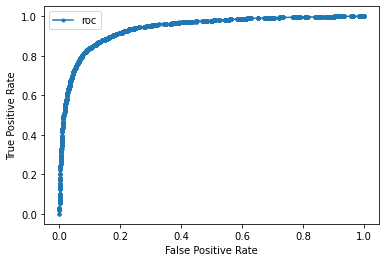

auc = 0.9390943121336631
threshold = 0.15459605265240228
f1_score = 0.8042269359335767


In [17]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

y_true = []
y_pred = []
y_prob = []

for sample in samples:
	pred, prob = calcualte_NB_predicted_probabilities(prior, conditional, sample)
	y_pred.append(pred)
	y_prob.append(prob)
	y_true.append(sample['risk'])
 
evaluation(y_true, y_pred)

### Evaluate Ground Truth Model - Sampling Based Approach

In [18]:
def construct_evidence_key(sample):
  evidence = np.empty(len(sample.keys()))

  for key, value in sample.items():
    if key == 'risk':
      continue

    index = feature_index_map[key]
    evidence[index] = value

  return np.array_str(evidence)

In [19]:
def calculate_normalized_high_prob_given_features(samples):
  evidence_count_map = {} 

  for sample in samples:
    evidence_key = construct_evidence_key(sample)
    current_risk = sample['risk']

    if evidence_key in evidence_count_map.keys():
      low, high = evidence_count_map[evidence_key] 

      if current_risk == 0:
        evidence_count_map[evidence_key] = (low + 1, high)
      else:
        evidence_count_map[evidence_key] = (low, high + 1)

    else:
      if current_risk == 0:
        evidence_count_map[evidence_key] = (1, 0)
      else:
        evidence_count_map[evidence_key] = (0, 1)

  normalized_high_prob_map = {}
  for key, value in evidence_count_map.items():
    low, high = value
    normalized_high_prob_map[key] = high / (high + low)

  return normalized_high_prob_map

In [20]:
def calcualte_ground_truth_label(samples, normalized_high_prob_map, threshold = 0.3023255813953488):

  y_true = []
  y_pred = []
  y_prob = []

  for sample in samples:
    evidence_key = construct_evidence_key(sample)
    normalized_high_prob = normalized_high_prob_map[evidence_key]

    pred = 1 if normalized_high_prob > threshold else 0 
    y_pred.append(pred)
    y_prob.append(normalized_high_prob)
    y_true.append(sample['risk'])
 
  evaluation(y_true, y_pred)

In [21]:
normalized_high_prob_map = calculate_normalized_high_prob_given_features(samples)  # i.e. inference through counting sampling data

precision = 0.8055401338281273
recall = 0.9155154091392136


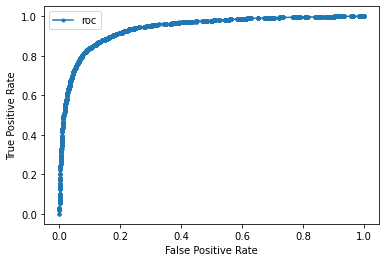

auc = 0.9390943121336631
threshold = 0.15459605265240228
f1_score = 0.857014066993083


In [22]:
calcualte_ground_truth_label(samples, normalized_high_prob_map)

### Evaluate Ground Truth Model - Factor Graph Based Approach

In [23]:
from pomegranate import *

In [24]:
age = DiscreteDistribution({0: 0.03518,
                            1: 0.02412,
                            2: 0.12161,
                            3: 0.17789,
                            4: 0.13266,
                            5: 0.18392,
                            6: 0.14271,
                            7: 0.11055,
                            8: 0.07136})
gender = DiscreteDistribution({0: 0.58193, 1: 0.41807}) # Male: 0  Female: 1
chronical_disease = ConditionalProbabilityTable( # [false, true]
        [[0, 0, 0, 0.928571429],
         [0, 0, 1, 0.071428571],
         [0, 1, 0, 0.923076923],
         [0, 1, 1, 0.076923077],
         [1, 0, 0, 0.928571429],
         [1, 0, 1, 0.071428571],
         [1, 1, 0, 0.928571429],
         [1, 1, 1, 0.071428571],
         [2, 0, 0, 0.980392157],
         [2, 0, 1, 0.019607843],
         [2, 1, 0, 0.945945946],
         [2, 1, 1, 0.054054054],
         [3, 0, 0, 0.95],
         [3, 0, 1, 0.05],
         [3, 1, 0, 0.972972973],
         [3, 1, 1, 0.027027027],
         [4, 0, 0, 0.903846154],
         [4, 0, 1, 0.096153846],
         [4, 1, 0, 0.894736842],
         [4, 1, 1, 0.105263158],
         [5, 0, 0, 0.742424242],
         [5, 0, 1, 0.257575758],
         [5, 1, 0, 0.884615385],
         [5, 1, 1, 0.115384615],
         [6, 0, 0, 0.578947368],
         [6, 0, 1, 0.421052632],
         [6, 1, 0, 0.696969697],
         [6, 1, 1, 0.303030303],
         [7, 0, 0, 0.442307692],
         [7, 0, 1, 0.557692308],
         [7, 1, 0, 0.714285714],
         [7, 1, 1, 0.285714286],
         [8, 0, 0, 0.515151515],
         [8, 0, 1, 0.484848485],
         [8, 1, 0, 0.647058824],
         [8, 1, 1, 0.352941176]], [age, gender])
risk_factor = ConditionalProbabilityTable( # [low, high]
        [[0, 0, 1, 0, 0.5],
         [0, 0, 1, 1, 0.5],
         [0, 0, 0, 0, 0.928571429],
         [0, 0, 0, 1, 0.071428571],
         [0, 1, 1, 0, 0.5],
         [0, 1, 1, 1, 0.5],
         [0, 1, 0, 0, 0.923076923],
         [0, 1, 0, 1, 0.076923077],
         [1, 0, 1, 0, 0.5],
         [1, 0, 1, 1, 0.5],
         [1, 0, 0, 0, 0.928571429],
         [1, 0, 0, 1, 0.071428571],
         [1, 1, 1, 0, 0.5],
         [1, 1, 1, 1, 0.5],
         [1, 1, 0, 0, 0.9],
         [1, 1, 0, 1, 0.1],
         [2, 0, 1, 0, 0.5],
         [2, 0, 1, 1, 0.5],
         [2, 0, 0, 0, 0.980392157],
         [2, 0, 0, 1, 0.019607843],
         [2, 1, 1, 0, 0.666666667],
         [2, 1, 1, 1, 0.333333333],
         [2, 1, 0, 0, 0.972222222],
         [2, 1, 0, 1, 0.027777778],
         [3, 0, 1, 0, 0.6],
         [3, 0, 1, 1, 0.4],
         [3, 0, 0, 0, 0.922077922],
         [3, 0, 0, 1, 0.077922078],
         [3, 1, 1, 0, 0.5],
         [3, 1, 1, 1, 0.5],
         [3, 1, 0, 0, 0.972972973],
         [3, 1, 0, 1, 0.027027027],
         [4, 0, 1, 0, 0.166666667],
         [4, 0, 1, 1, 0.833333333],
         [4, 0, 0, 0, 0.875],
         [4, 0, 0, 1, 0.125],
         [4, 1, 1, 0, 0.4],
         [4, 1, 1, 1, 0.6],
         [4, 1, 0, 0, 0.971428571],
         [4, 1, 0, 1, 0.028571429],
         [5, 0, 1, 0, 0.277777778],
         [5, 0, 1, 1, 0.722222222],
         [5, 0, 0, 0, 0.76],
         [5, 0, 0, 1, 0.24],
         [5, 1, 1, 0, 0.333333333],
         [5, 1, 1, 1, 0.666666667],
         [5, 1, 0, 0, 0.972222222],
         [5, 1, 0, 1, 0.027777778],
         [6, 0, 1, 0, 0.16],
         [6, 0, 1, 1, 0.84],
         [6, 0, 0, 0, 0.647058824],
         [6, 0, 0, 1, 0.352941176],
         [6, 1, 1, 0, 0.181818182],
         [6, 1, 1, 1, 0.818181818],
         [6, 1, 0, 0, 0.75],
         [6, 1, 0, 1, 0.25],
         [7, 0, 1, 0, 0.233333333],
         [7, 0, 1, 1, 0.766666667],
         [7, 0, 0, 0, 0.416666667],
         [7, 0, 0, 1, 0.583333333],
         [7, 1, 1, 0, 0.181818182],
         [7, 1, 1, 1, 0.818181818],
         [7, 1, 0, 0, 0.384615385],
         [7, 1, 0, 1, 0.615384615],
         [8, 0, 1, 0, 0.058823529],
         [8, 0, 1, 1, 0.941176471],
         [8, 0, 0, 0, 0.166666667],
         [8, 0, 0, 1, 0.833333333],
         [8, 1, 1, 0, 0.230769231],
         [8, 1, 1, 1, 0.769230769],
         [8, 1, 0, 0, 0.043478261],
         [8, 1, 0, 1, 0.956521739]], [age, gender, chronical_disease])

fever = ConditionalProbabilityTable([
    [0, 0, 0.25],
    [0, 1, 0.75],
    [1, 0, 0.682759],
    [1, 1, 0.317241]
], [risk_factor])

cough = ConditionalProbabilityTable([
    [0, 0, 0.38542],
    [0, 1, 0.61458],
    [1, 0, 0.79412],
    [1, 1, 0.20588]
], [risk_factor])

shortness = ConditionalProbabilityTable([
    [0, 0, 0.78235],
    [0, 1, 0.21765],
    [1, 0, 0.28169],
    [1, 1, 0.71831]
], [risk_factor])

sputum = ConditionalProbabilityTable([
    [0, 0, 0.96319],
    [0, 1, 0.03681],
    [1, 0, 0.96429],
    [1, 1, 0.03571]
], [risk_factor])

diarrhea = ConditionalProbabilityTable([
    [0, 0, 0.96319],
    [0, 1, 0.03681],
    [1, 0, 0.97857],
    [1, 1, 0.02143]
], [risk_factor])

myalgia = ConditionalProbabilityTable([
    [0, 0, 0.90071],
    [0, 1, 0.09929],
    [1, 0, 0.9635],
    [1, 1, 0.0365]
], [risk_factor])

headache = ConditionalProbabilityTable([
    [0, 0, 0.89744],
    [0, 1, 0.10256],
    [1, 0, 0.97744],
    [1, 1, 0.02256]
], [risk_factor])

chest = ConditionalProbabilityTable([
    [0, 0, 0.97403],
    [0, 1, 0.02597],
    [1, 0, 0.98496],
    [1, 1, 0.01504]
], [risk_factor])

heart = ConditionalProbabilityTable([
    [0, 0, 1.0],
    [0, 1, 0],
    [1, 0, 0.85714],
    [1, 1, 0.14286]
], [risk_factor])

fatigue = ConditionalProbabilityTable([
    [0, 0, 0.11852],
    [0, 1, 0.88148],
    [1, 0, 0.09489],
    [1, 1, 0.90511]
], [risk_factor])

In [25]:
s_age = State(age, name="age")
s_gender = State(gender, name="gender")
s_chronical_disease = State(chronical_disease, name="chronical")
s_risk_factor = State(risk_factor, name="risk")
s_fever = State(fever, name="fever_risk")
s_cough = State(cough, name="cough_risk")
s_shortness = State(shortness, name="shortness_risk")
s_sputum = State(sputum, name="sputum_risk")
s_diarrhea = State(diarrhea, name="diarrhea_risk")
s_myalgia = State(myalgia, name="myalgia_risk")
s_headache = State(headache, name="headache_risk")
s_chest = State(chest, name="chest_risk")
s_heart = State(heart, name="heart_risk")
s_fatigue = State(fatigue, name="fatigue_risk")

In [26]:
model = BayesianNetwork("Ground Truth Model")
model.add_states(s_age, s_gender, s_chronical_disease, s_risk_factor, s_fever, s_cough, s_shortness, s_sputum, s_diarrhea, s_myalgia, 
                 s_headache, s_chest, s_heart, s_fatigue)

In [27]:
model.add_edge(s_age, s_chronical_disease)
model.add_edge(s_gender, s_chronical_disease)
model.add_edge(s_age, s_risk_factor)
model.add_edge(s_gender, s_risk_factor)
model.add_edge(s_chronical_disease, s_risk_factor)
model.add_edge(s_risk_factor, s_fever)
model.add_edge(s_risk_factor, s_cough)
model.add_edge(s_risk_factor, s_shortness)
model.add_edge(s_risk_factor, s_sputum)
model.add_edge(s_risk_factor, s_diarrhea)
model.add_edge(s_risk_factor, s_myalgia)
model.add_edge(s_risk_factor, s_headache)
model.add_edge(s_risk_factor, s_chest)
model.add_edge(s_risk_factor, s_heart)
model.add_edge(s_risk_factor, s_fatigue)
model.bake()

In [28]:
import copy
samples_copy = copy.deepcopy(samples)
for sample in samples_copy:
    del sample['risk']

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

y_true = []
y_pred = []
y_prob = []
threshold = 0.2889292237691417

for index, sample in enumerate(samples):
    prob = model.predict_proba(samples_copy[index])[3].parameters[0][1]
    pred = 1 if prob > 0.5 else 0
    y_pred.append(pred)
    y_prob.append(prob)
    y_true.append(sample['risk'])
 
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
auc = metrics.auc(fpr, tpr)

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print("precision = {}".format(precision))
print("recall = {}".format(recall))
print("auc = {}".format(auc))

precision = 0.8733259699019743
recall = 0.8402630180658873
auc = 0.9673134448794252


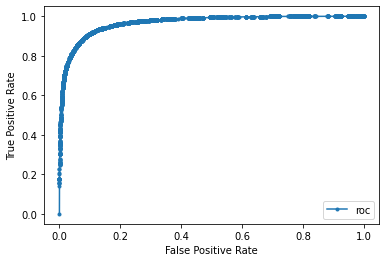

In [30]:
plot_roc(fpr, tpr)

In [31]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

0.29807350272999833
